# Analysis of borrowers reliabilty 

**Study purpose:** To check if marital status and the number of children affect on returning loan on time.

### Step 1. Data overview

In [1]:
import pandas as pd
import seaborn as sns

In [ ]:
try:
    data = pd.read_csv('data.csv')
except:
    data = pd.read_csv('/datasets/data.csv')

display(data.head(20))

In [3]:
# information re data in the table
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [ ]:
data.describe()

Table contains 12 columns. Of which 4 are quantitative variables and 8 - categorial.
Data has following problems:
- missing values (in columns days_employed and total_income), 
- lowercase mixed with uppercase in one column, 
- anomalies in form of negative values in number of working years and number of kids

### Step 2.1 Missing data processing

Proportion of missing values in columns days_employed and total_income:

In [5]:
print('Proportion of missing values in column days_employed:', data['days_employed'].isna().sum() / len(data['days_employed']))
print('Proportion of missing values in column total_income:', data['total_income'].isna().sum() / len(data['days_employed']))

Proportion of missing values in column days_employed: 0.10099883855981417
Proportion of missing values in column total_income: 0.10099883855981417


<AxesSubplot:>

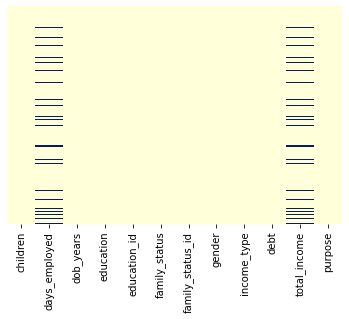

In [6]:
sns.heatmap(data.isna(), yticklabels=False, cbar=False, cmap="YlGnBu")

Amount of missing values is the same for both columns. On the heatmap above we can see visual representation of which rows contain missing values. We can assume that on the time of application for loan, the client is not employed, therefore does not have any income and left the field empty.

In the data sample there can be values that may drastically differ from the true mean value and, therefore, alter the calculations. It is prefered to replace blanks with median values.

In [7]:
# Creation of list with unique types of income
data_income_type = data['income_type'].unique()
data_income_type = data_income_type.tolist()

# Replacing blanks in total_income column with median value for the particular type of income
for type in data_income_type:
    income_median = data.loc[data['income_type'] == type, 'total_income'].median()
    data.loc[data['income_type'] == type, 'total_income'] = data.loc[data['income_type'] == type, 'total_income'].fillna(income_median)


In [ ]:
data.info()
display(data.head(15))

### Step 2.2 Anomalies processing

<b>Elimination of anomalies in days_employed column</b>

In the days_employed column negative values prevail. In the first 20 rows of the table we can notice that only pensioners have positive values as work experience.

In [9]:
# Check for median values for work experience for each type of income
data.groupby('income_type')['days_employed'].median()

income_type
безработный        366413.652744
в декрете           -3296.759962
госслужащий         -2689.368353
компаньон           -1547.382223
пенсионер          365213.306266
предприниматель      -520.848083
сотрудник           -1574.202821
студент              -578.751554
Name: days_employed, dtype: float64

Only unemployed clients and pensioners have positive working experience.

In [ ]:
# Replacing negative values with positive
def correct_value(row):
    days = row['days_employed']
    source = row['income_type']
    if days < 0: 
        return abs(days)
    else:
        return days

data['days_employed'] = data.apply(correct_value, axis=1)
display(data.head(20))

In [11]:
# Filling in blanks with median in days_employed column
days_drop_null = data[data['days_employed'].isna() == False]
data['days_employed'] = data['days_employed'].fillna(days_drop_null['days_employed'].median())

In [ ]:
data.info()
display(data.head(15))

<b>Elimination of anomalies in children column</b>

In [13]:
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [14]:
# Getting absolute value for negative amiunt of children
data['children'] = abs(data['children'])
data['children'].value_counts()

0     14149
1      4865
2      2055
3       330
20       76
4        41
5         9
Name: children, dtype: int64

In [15]:
# Correcting typo: replacing 20 children with 2
data.loc[data['children'] == 20, 'children'] = 2
data['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

### Step 2.3. Correcting type of data

In [ ]:
# Correcting type in days_employed column
data['days_employed'] = data['days_employed'].astype('int')
display(data.head())

### Step 2.4. Elimination of duplicates

In [17]:
data['education'] = data['education'].str.lower()
print('Number of duplicates:', data[data.duplicated()]['days_employed'].count())

Number of duplicates: 71


In [ ]:
# Deleting duplicates
data = data.drop_duplicates().reset_index(drop=True)
data.info()

In [19]:
# Checking for anomalies in gender column
data['gender'].value_counts()

F      14174
M       7279
XNA        1
Name: gender, dtype: int64

In [ ]:
data[data['gender'] == 'XNA']

Checking 'gender' column resulted in one anomaly, client forgot to mention their gender. Since we cannot process the error (cannot substitute it with any value), we should delete the record.

In [21]:
#Deleting the record with an empty value
data = data[data['gender'] != 'XNA']
data['gender'].value_counts()

F    14174
M     7279
Name: gender, dtype: int64

### Step 2.5. Creation of additional dataframes, decomposition of the initial dataframe.

<b>Creation of dataframe education:</b>

In [22]:
education = data[['education', 'education_id']].drop_duplicates().reset_index(drop=True)
display(education)

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


<b>Creation of dataframe family:</b>

In [23]:
family = data[['family_status', 'family_status_id']].drop_duplicates().reset_index(drop=True)
display(family)

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


In [ ]:
# Deleting columns 'education' and 'family_status' from the initial dataframe

data = data.drop('education', axis=1)
data = data.drop('family_status', axis=1)
display(data.head())

### Step 2.6. Income categorisation.

Adding a column with categories for clients based on their income:

In [25]:
def total_income_count(row):
    income = row['total_income']
    if 0 <= income <= 30000:
        return 'E'
    if 30001 <= income <= 50000:
        return 'D'
    if 50001 <= income <= 200000:
        return 'C'
    if 200001 <= income <= 1000000:
        return 'B'
    if income >= 1000001:
        return 'A'

data['total_income_category'] = data.apply(total_income_count, axis=1)
display(data['total_income_category'].value_counts())

C    16015
B     5041
D      350
A       25
E       22
Name: total_income_category, dtype: int64

### Step 2.7. Purpose of loan categorisation.

Adding a column with categories for clients based on their purpose for loan:

In [ ]:
def purpose_categorize(row):
    purpose = row['purpose']
    if 'автомобил' in purpose:
        return 'operation with a car'
    if 'образовани' in purpose:
        return 'for education'
    if 'жиль' in purpose or 'недвижимост' in purpose:
        return 'operation with a property'
    elif 'свадьб' in purpose:
        return 'for a wedding'

data['purpose_category'] = data.apply(purpose_categorize, axis=1)
display(data.head(10))
data['purpose_category'].value_counts()

<b>Is there a correlation between number of children and returning a loan on time?</b>

In [27]:
df_children = data.pivot_table(index = 'children', values = 'debt', 
                            aggfunc = ['count', 'sum', 'mean', lambda x: 1 - x.mean()])
df_children.columns = ['Amount of clients', 'Amount of debtors', '% of debtors', '% of non-debtors']
df_children.style.format({'% of debtors': '{:.2%}', '% of non-debtors': '{:.2%}'})

,Amount of clients,Amount of debtors,% of debtors,% of non-debtors
children,,,,
0,14090,1063,7.54%,92.46%
1,4855,445,9.17%,90.83%
2,2128,202,9.49%,90.51%
3,330,27,8.18%,91.82%
4,41,4,9.76%,90.24%
5,9,0,0.00%,100.00%


There is no direct correlation between number of children and returning loan on time. All of the clients with 5 children payed back on time.
On the second place there are clients with no kids.
We cannot be sure that the more children client has, the more the probability of returning the loan on time and vice versa.

<b>Is there a correlation between family status and returning a loan on time?</b>

In [28]:
family_depend = data.pivot_table(index='family_status_id', values='debt', aggfunc=['count', 'sum', 'mean', lambda x: 1 - x.mean()])
family_depend.columns = family_depend.columns.droplevel(1)

family_depend = family_depend.merge(family, on='family_status_id', how='left').reset_index(drop=True)

family_depend.columns = ['family_status_id', 'Number of clients', 'Amount of debtors', '% of debtors', '% of non-debtors', 'Family status']
family_depend.style.format({'% of debtors': '{:.2%}', '% of non-debtors': '{:.2%}'})


,family_status_id,Number of clients,Amount of debtors,% of debtors,% of non-debtors,Family status
0,0,12339,931,7.55%,92.45%,женат / замужем
1,1,4150,388,9.35%,90.65%,гражданский брак
2,2,959,63,6.57%,93.43%,вдовец / вдова
3,3,1195,85,7.11%,92.89%,в разводе
4,4,2810,274,9.75%,90.25%,Не женат / не замужем


Most of the time single clients and clients with a partner, but non-married return loans with a delay. Only 6.6% of widowers/widows payed back with a delay.

<b>Is there a correlation between income category and returning a loan on time?</b>

In [29]:
income_depend = data.pivot_table(index = 'total_income_category', values = 'debt', 
                            aggfunc = ['count', 'sum', 'mean', lambda x: 1 - x.mean()])
income_depend.columns = ['Amount of clients', 'Amount of debtors', '% of debtors', '% of non-debtors']
income_depend.style.format({'% of debtors': '{:.2%}', '% of non-debtors': '{:.2%}'})

,Amount of clients,Amount of debtors,% of debtors,% of non-debtors
total_income_category,,,,
A,25,2,8.00%,92.00%
B,5041,356,7.06%,92.94%
C,16015,1360,8.49%,91.51%
D,350,21,6.00%,94.00%
E,22,2,9.09%,90.91%


94% of clients from the income category D (income ranges between 30k and 50k) payed back in a timely manner. 9% of clients from the income category E (income below 30k) payed back with a delay.
There is no visible conclusion that the more the income, the better the repayment rate.

<b>How the repayment on time depends on the purpose of loan?</b>

In [30]:
purpose_depend = data.pivot_table(index='purpose_category', values='debt', aggfunc=['count', 'mean'])
purpose_depend

,count,mean
,debt,debt
purpose_category,,
for a wedding,2324,0.080034
for education,4013,0.092200
operation with a car,4306,0.093590
operation with a property,10810,0.072340


The majority of loans were initialised with a purpose of 'operations with a property' and this category has the most successful repayment rate. 
Number of loans with a purpose of 'education' or 'operations with a car' is almost the same, so is the number of clients that payed back on time, around 90%.

## Conclusion:

Data was preprocessed: 
* empty values in 'income' were filled with medians based on the income source, 
* empty values in 'days_employed' were filled with medians,
* negative values in 'days_employed' were corrected,
* duplicates were removed,
* anomalies in the number of children were corrected.

Clients were also categorised based on their income and purpose for loan.

The analysis showed us that female clients applied for a loan two times more often than male clients. Main client group were clients with income category 'C' (income range is between 50k and 200k). The majority of loans were registered with a purpose of operation with a property.

There was no direct correlation between the number of children / family status / income and client's reliability. However, there is a possible dependency on a purpose, big loans and important purposes (purchase of a property) have more success in repayment on time.